In [69]:
import cv2
import torch
import urllib.request
import ssl
import numpy as np
from stl import mesh
import open3d as o3d
import matplotlib.pyplot as plt
from transformers import pipeline


In [70]:

ssl._create_default_https_context = ssl._create_unverified_context

In [71]:

def get_depth_map_midas(image_path):
    # code from https://pytorch.org/hub/intelisl_midas_v2/
    # this code is used to get the depth map of the image

    # Load a model
    model_type = "DPT_Large" 
    midas = torch.hub.load("intel-isl/MiDaS", model_type)


    # Load transforms to resize and normalize the image for large or small model
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform


    # Load image and apply transforms
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    input_batch = transform(img_rgb).to(device)


    # predict and resize to original image size
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    normalized_depth = (output - output.min()) / (output.max() - output.min())
    plt.imshow(output)
    plt.show()

    return normalized_depth, img_rgb

In [77]:

def get_depth_map_transformer(image_path):
    # https://huggingface.co/tasks/depth-estimation
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    estimator = pipeline(task="depth-estimation", model="Intel/dpt-large")
    result = estimator(images=image_path)
    depth_map = np.array(result["depth"]).astype(np.float32)

    normalized_depth = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    plt.imshow(normalized_depth, cmap='plasma')  # optional colormap for better contrast
    plt.title("Relative Depth Visualization from MiDaS")
    plt.axis('off')
    plt.show()
    
    return normalized_depth, img_rgb


In [73]:


def compute_detail_map(normalized_depth, img, depth_layer=12):
    gray_img = np.mean(img, axis=2).astype(np.uint8)
    global_edges = cv2.Canny(gray_img, 50, 150)
    partition_thresholds = np.linspace(0, 1, depth_layer + 1) ** 2
    detail_map = []
    for i in range(depth_layer):
        layer_mask = (normalized_depth >= partition_thresholds[i]) & (normalized_depth < partition_thresholds[i+1])
        layer_detail_edge = np.zeros_like(global_edges, dtype=np.float32)
        layer_detail_edge[layer_mask] = global_edges[layer_mask] / 255.0
        detail_map.append(layer_detail_edge)
        if i == 10:
  
            plt.imshow(layer_detail_edge, cmap='gray')
            plt.title("Edge outlines at depth layer 10")
            plt.axis('off')
            plt.show()

            masked_depth_map = np.full_like(normalized_depth, np.nan)
            masked_depth_map[layer_mask] = normalized_depth[layer_mask]

            # Show depth values in original positions with colors mapped by value
            plt.imshow(masked_depth_map, cmap='plasma')
            plt.title("Relative Depth Visualization at Depth Layer 10")
            plt.axis('off')
            plt.colorbar(label='Normalized Depth')
            plt.show()
            
    combined_detail_map = np.sum(np.array(detail_map), axis=0)
     # For visualization:
    plt.imshow(combined_detail_map, cmap='gray')
    plt.title("Combined Filled Edge Regions Across All Depth Layers")
    plt.axis('off')
    plt.show()
    return combined_detail_map


In [74]:
def fill_inner_area_from_edges(edge_img):
    kernel = np.ones((5, 5), np.uint8)
    closed_edges = cv2.morphologyEx(edge_img, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled_mask = np.zeros_like(edge_img)
    cv2.drawContours(filled_mask, contours, -1, 255, thickness=cv2.FILLED)
    return filled_mask

def create_watertight_and_smoothed_mesh(
    normalized_depth, img,
    scale, base_thickness, detail_scale, grayscale_detail_weight,
    stl_filename="model.stl",
    smooth_type="none",
    smooth_iters
):
    H, W = normalized_depth.shape
    detail_map = compute_detail_map(normalized_depth, img)
    gray_img = np.mean(img, axis=2).astype(np.float32) / 255.0
    gray_img = cv2.GaussianBlur(gray_img, (3, 3), 2)
    gray_detail_scaled = gray_img * grayscale_detail_weight
    filled_global = fill_inner_area_from_edges(cv2.Canny(gray_img.astype(np.uint8) * 255, 50, 150)) / 255.0
    global_edges_dilated = cv2.dilate(cv2.Canny(gray_img.astype(np.uint8) * 255, 50, 150), np.ones((3, 3), np.uint8), iterations=1) / 255.0

    #Test This More
    height_map = (
        cv2.GaussianBlur(normalized_depth, (5, 5), 1.5) * scale +
        filled_global * detail_scale +
        global_edges_dilated * 1.0 +
        gray_detail_scaled + detail_map
    )

    xx, yy = np.meshgrid(np.arange(W), np.arange(H))
    z_top = height_map.astype(int)
    z_bottom = np.full_like(z_top, -base_thickness)
    vertices_top = np.column_stack((xx.ravel(), yy.ravel(), z_top.ravel()))
    vertices_bottom = np.column_stack((xx.ravel(), yy.ravel(), z_bottom.ravel()))
    vertices = np.vstack((vertices_top, vertices_bottom))
    total_vertices = H * W

    faces = []
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j
            v2 = i * W + (j + 1)
            v3 = (i + 1) * W + j
            v4 = (i + 1) * W + (j + 1)
            faces.append([v1, v2, v3])
            faces.append([v3, v2, v4])
    for i in range(H - 1):
        for j in range(W - 1):
            v1 = i * W + j + total_vertices
            v2 = i * W + (j + 1) + total_vertices
            v3 = (i + 1) * W + j + total_vertices
            v4 = (i + 1) * W + (j + 1) + total_vertices
            faces.append([v1, v3, v2])
            faces.append([v3, v4, v2])
    for i in range(H - 1):
        v_top1 = i * W
        v_top2 = (i + 1) * W
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_top2, v_bot1])
        faces.append([v_top2, v_bot2, v_bot1])
    for i in range(H - 1):
        v_top1 = i * W + (W - 1)
        v_top2 = (i + 1) * W + (W - 1)
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_bot1, v_top2])
        faces.append([v_top2, v_bot1, v_bot2])
    for j in range(W - 1):
        v_top1 = j
        v_top2 = j + 1
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_bot1, v_top2])
        faces.append([v_top2, v_bot1, v_bot2])
    for j in range(W - 1):
        v_top1 = (H - 1) * W + j
        v_top2 = (H - 1) * W + j + 1
        v_bot1 = v_top1 + total_vertices
        v_bot2 = v_top2 + total_vertices
        faces.append([v_top1, v_top2, v_bot1])
        faces.append([v_top2, v_bot2, v_bot1])

    if smooth_type == "none":
        stl_mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
        stl_mesh.vectors = vertices[np.array(faces)]
        stl_mesh.save(stl_filename)
        print(f"Successfully generated STL: {stl_filename}")
    elif smooth_type == "smooth":

        mesh_o3d = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(vertices),
        o3d.utility.Vector3iVector(faces))


        mesh_o3d = mesh_o3d.filter_smooth_taubin(number_of_iterations=smooth_iters)

        mesh_o3d.compute_triangle_normals()
        mesh_o3d.compute_vertex_normals()

        # export back to STL
        o3d.io.write_triangle_mesh(stl_filename, mesh_o3d)



In [75]:
def generate_printable_model(
    image_path, smooth_iters, scale=150, base_thickness=8,
    detail_scale=5, grayscale_detail_weight=5,
    stl_filename="output.stl",
    smooth_type="smooth",
    
):
    normalized_depth, img = get_depth_map_transformer(image_path)
    create_watertight_and_smoothed_mesh(
        normalized_depth, img, scale, base_thickness,
        detail_scale, grayscale_detail_weight,
        stl_filename,
        smooth_type=smooth_type,
        smooth_iters=smooth_iters
    )


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


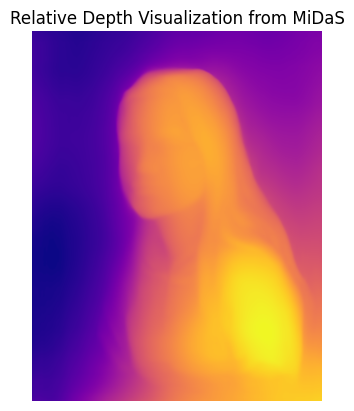

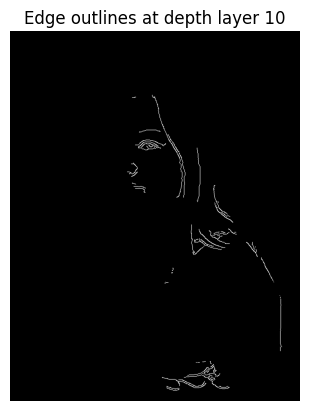

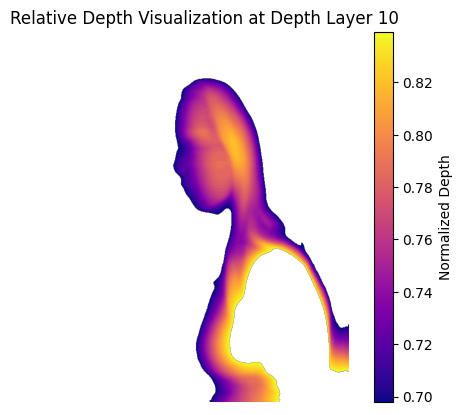

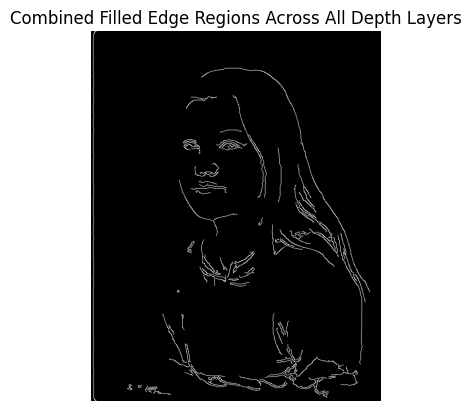

In [ ]:
generate_printable_model(
    "image/baseline/girl_figure.png",
    smooth_iters=20,
     scale=100, base_thickness=10,
     detail_scale=10, grayscale_detail_weight=8,
     smooth_iters=20,
     stl_filename="model/dev/girl_figure_20.stl",
)

In [66]:
image_file = ["image/simple_cartoon/lamb.png", "image/simple_cartoon/horse.png", "image/simple_cartoon/dragon.png", "image/baseline/3dbenchy.png", "image/baseline/girl_figure.png","image/cat/cat_ai.png", "image/custom/dad_sculpture.png","image/custom/black_cat.png"]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


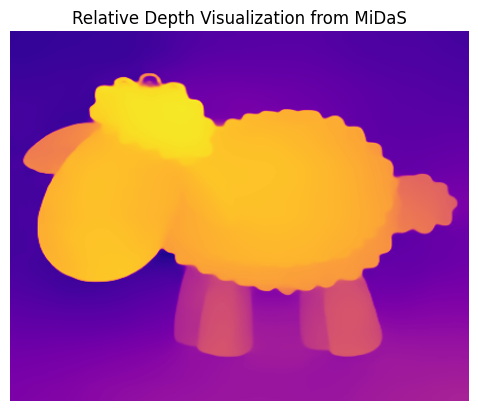

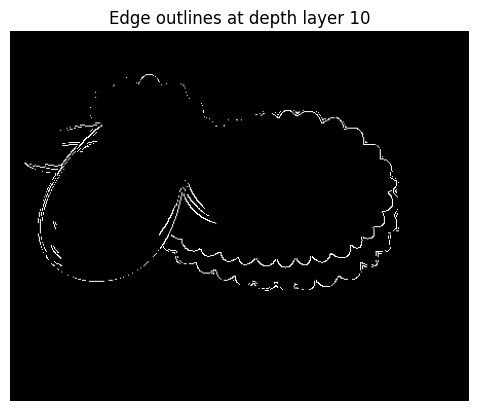

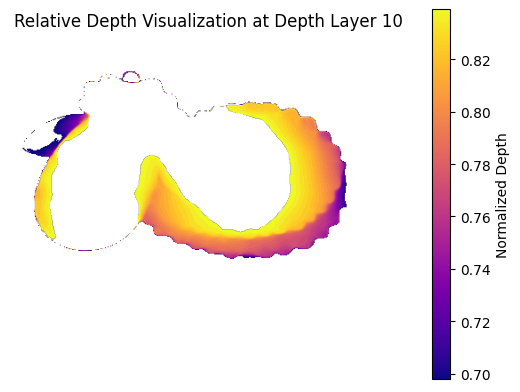

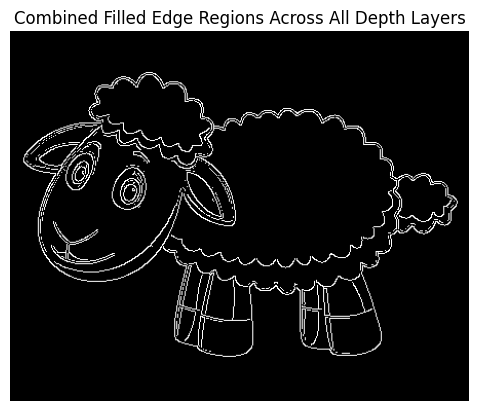

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


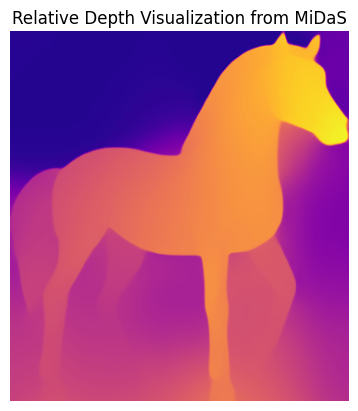

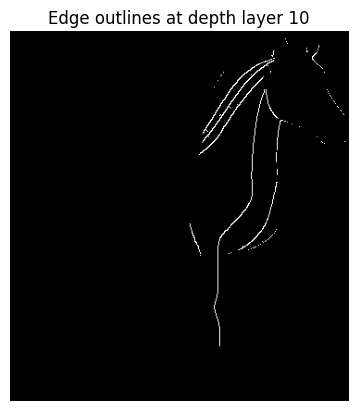

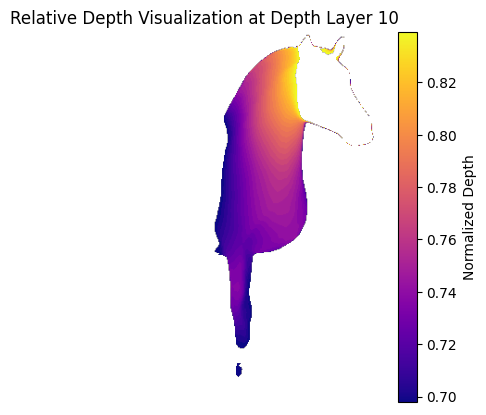

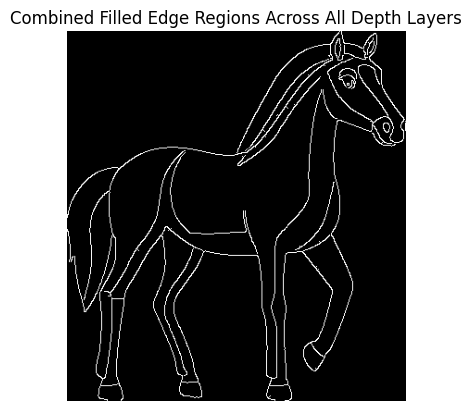

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


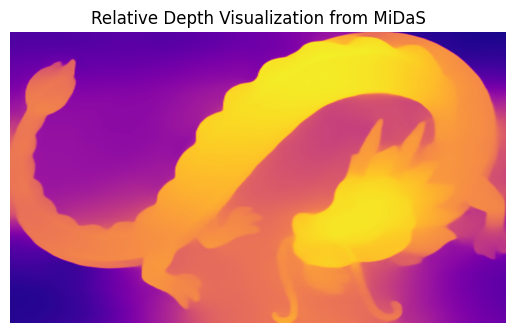

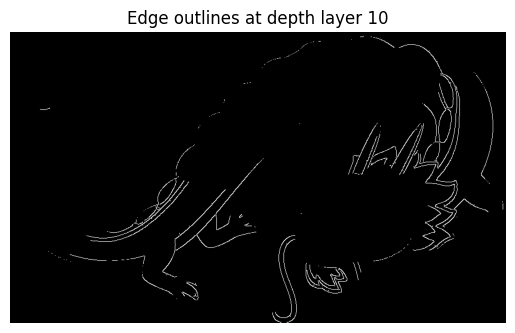

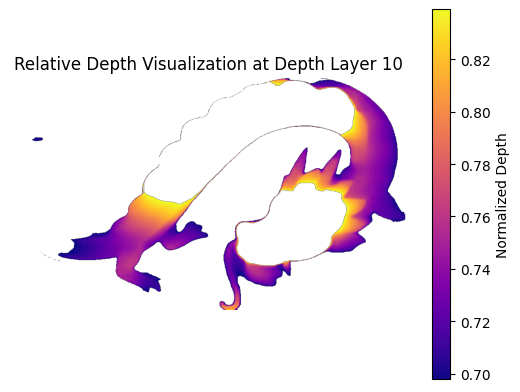

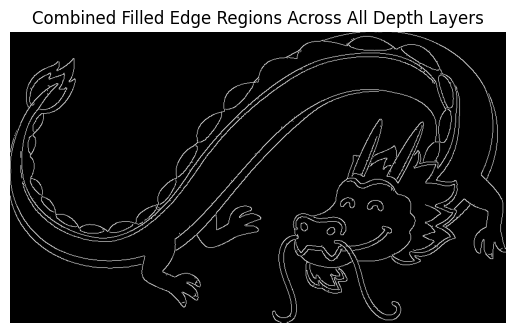

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


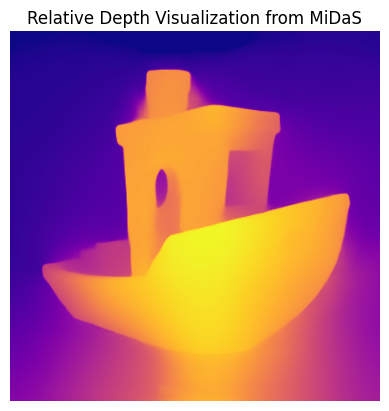

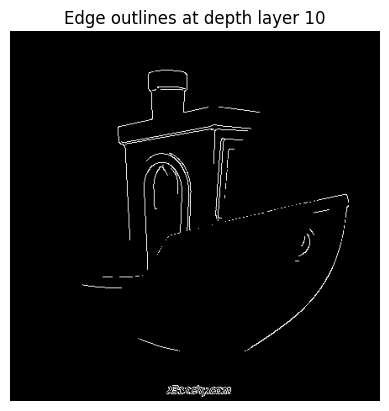

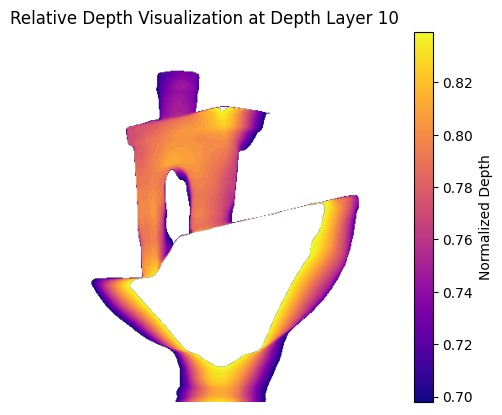

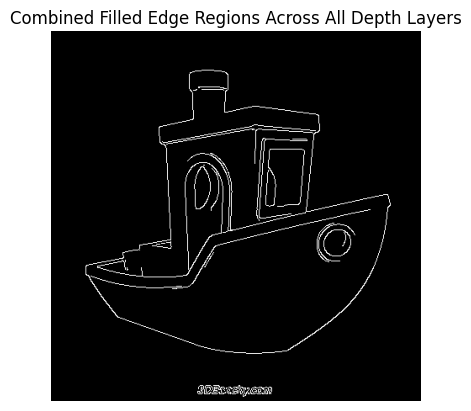

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


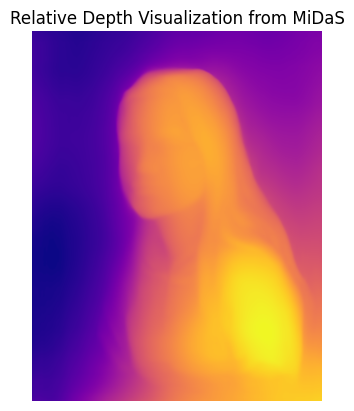

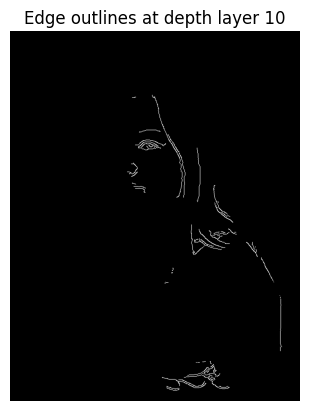

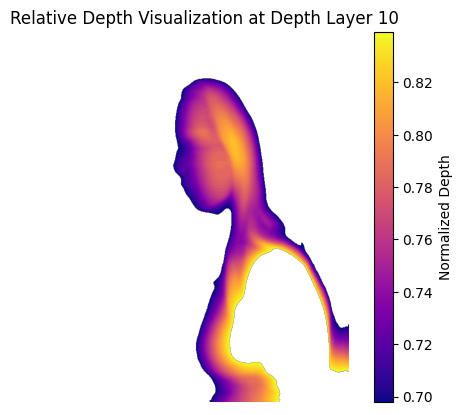

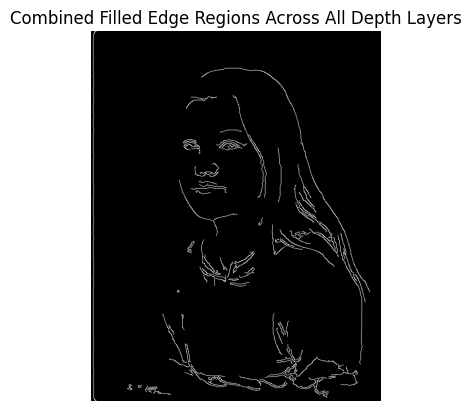

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


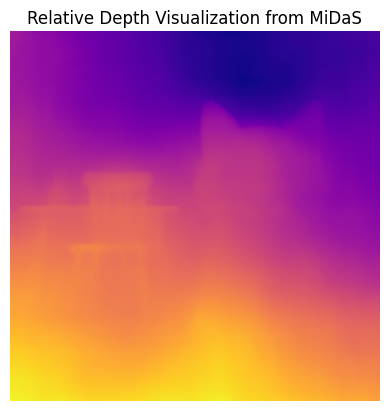

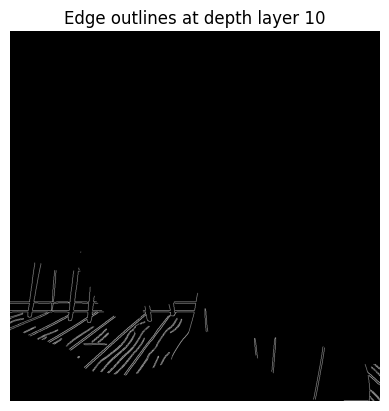

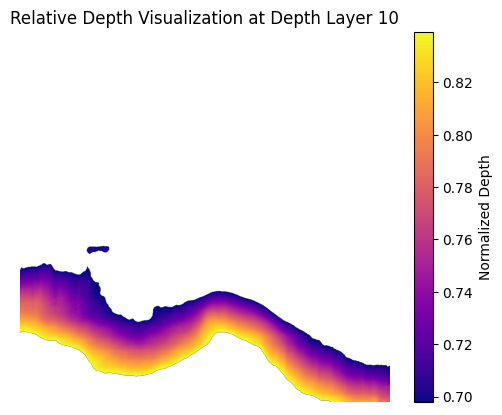

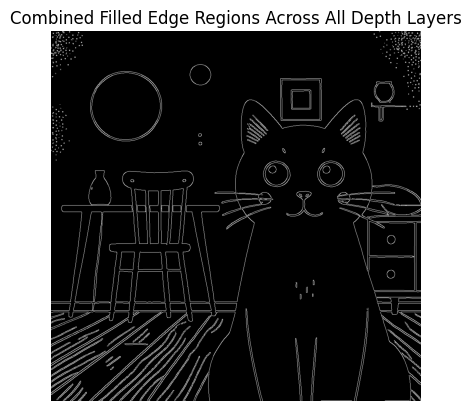

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


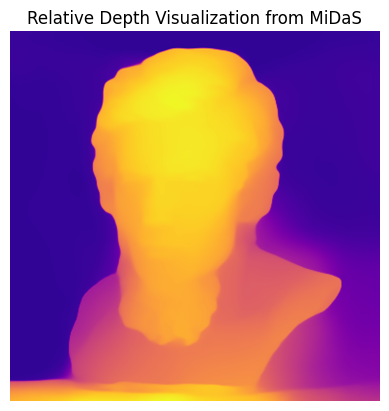

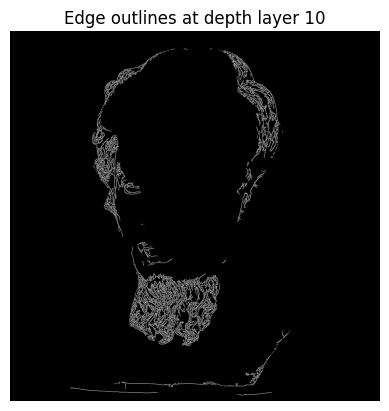

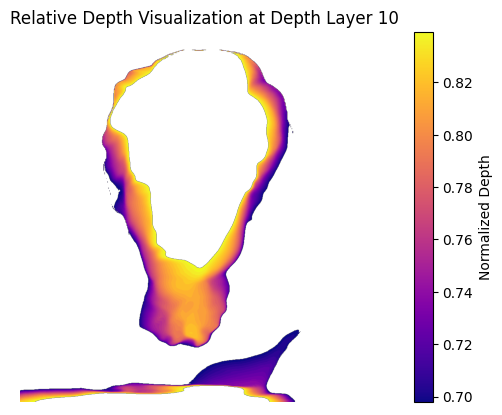

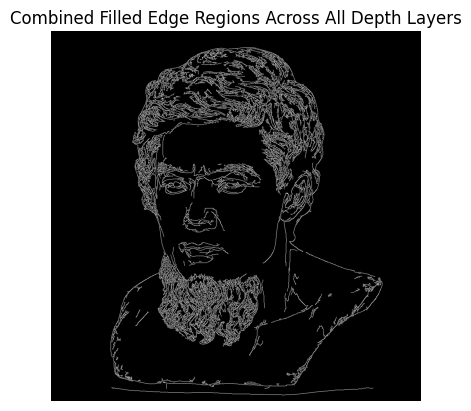

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


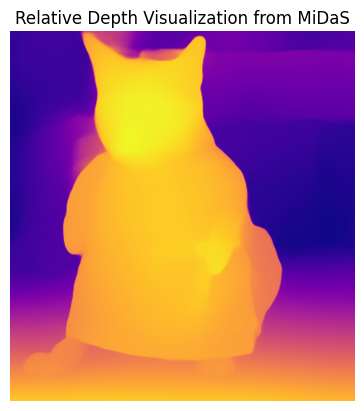

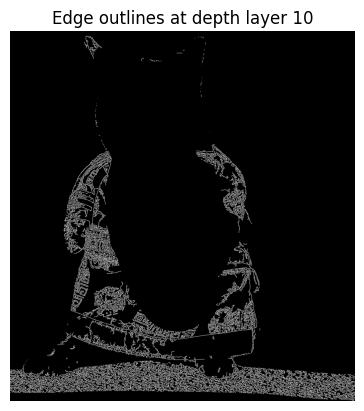

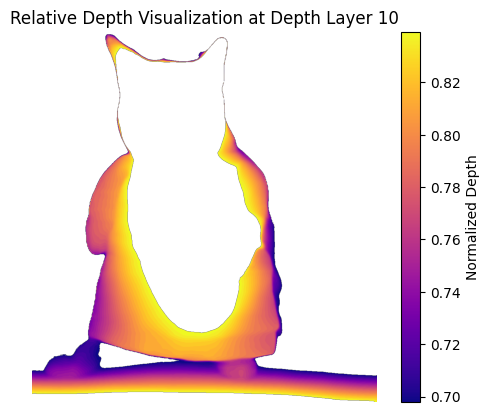

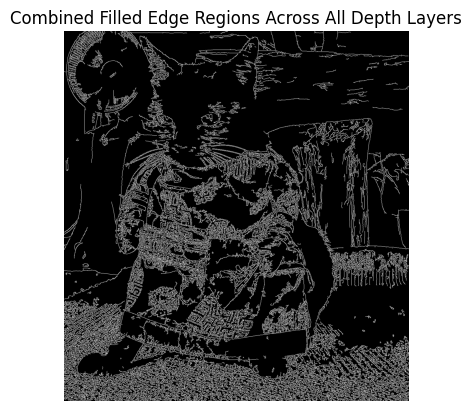

In [ ]:
for image_path in image_file:
    generate_printable_model(
    image_path,
     scale=100, base_thickness=10,
     detail_scale=10, grayscale_detail_weight=8,
     smooth_type="smooth",
     stl_filename="model/smooth/"+image_path.split("/")[-1]+".stl",
     smooth_iters=12,
    )